In [1]:
from pettingzoo.classic import connect_four_v3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [4]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [5]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [6]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [7]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

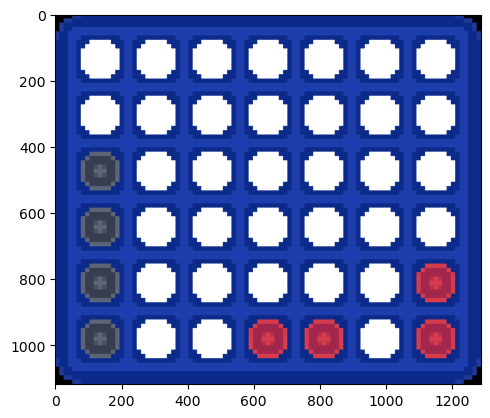

Player 1: Left Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 -1]
 [ 1  0  0 -1 -1  0 -1]]


1

In [8]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

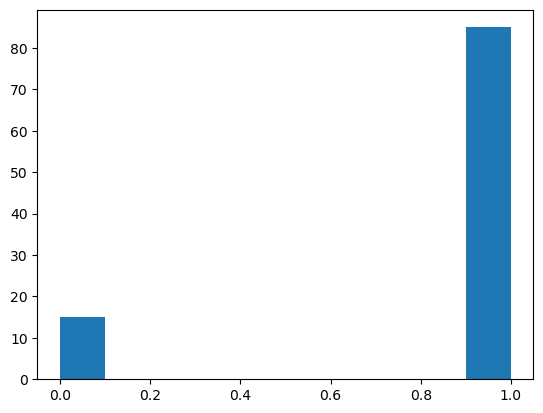

In [9]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [10]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [11]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

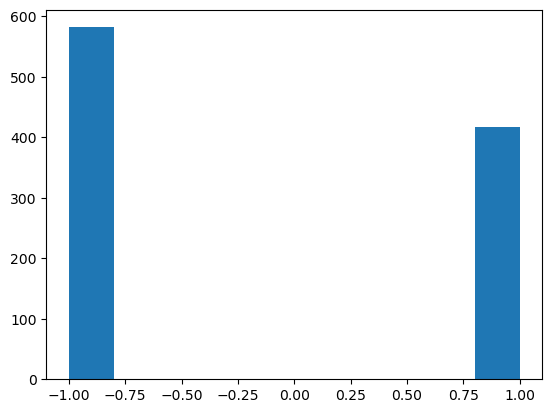

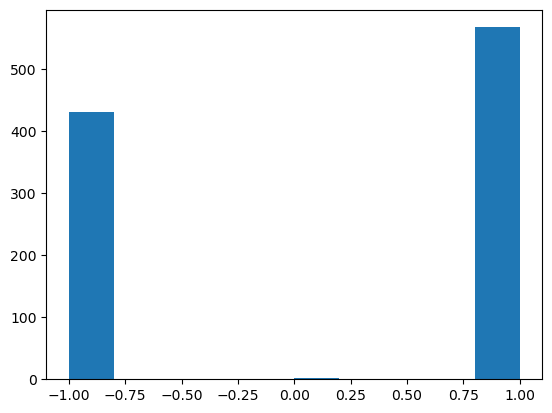

In [12]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




# MCTS

In [13]:
from math import sqrt,log
import copy

In [14]:
class MctsPlayer:
    def __init__(self,c,default_exploration_score):
        self.name = "MCTS Player"
        self.c=c
        self.default_exploration_score=default_exploration_score
        self.player_tree={}
        self.other_player={'player_0':'player_1','player_1':'player_0'}

    def monte_carlo_part(self,env,player):
        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            if termination or truncation:
                if agent==player:
                    victoire=(reward==1)
                if agent!=player:
                    victoire=(reward==-1)
                return victoire
            else:
                action=self.random_choice_with_mask(np.arange(7), observation["action_mask"])
            env.step(action)

    def choisir_action(self,state,exploration=True):
        score_max=-1000
        for child in self.player_tree[state]['children']:
            child_state=self.player_tree[state]['children'][child]
            if child_state in self.player_tree:
                w=self.player_tree[child_state]['nb_victories']
                n=self.player_tree[child_state]['nb_simulations']
                N=self.player_tree[state]['nb_simulations']
                score_perf=w/n
                score_explo=sqrt(log(N)/n)
            else:
                score_perf=0
                score_explo=self.default_exploration_score
            score=score_perf
            if exploration:
                score+=self.c*score_explo
            if score>score_max:
                score_max=score
                best_action=child
        return best_action
    
    def observation2state_index(self,env,player,action=None):
        obs, _, _, _, _ = env.last()
        tab=obs['observation'][:, :, 0]- obs['observation'][:, :, 1]
        if action!=None:
            for i in range(5,-1,-1):
                if tab[i,action]==0:
                    tab[i,action]=1
                    break
        result=[]
        for i in range(6):
            for j in range(7):
                if tab[i,j]==1:
                    result.append(player)
                elif tab[i,j]==-1:
                    result.append(self.other_player[player])
                else:
                    result.append(0)
        result=tuple(result)
        return result 


    def exploration(self,env,player):
        observation, reward, termination, truncation, info = env.last()
        state=self.observation2state_index(env,player)
        if state not in self.player_tree: # ie on est sur une feuille     
            self.player_tree[state]={'nb_simulations':1, 'nb_victories':0, 'children':{}}
            for action in range(7):
                if observation['action_mask'][action]==1:
                    child_state=self.observation2state_index(env,self.other_player[player],action)
                    self.player_tree[state]['children'][action]=child_state
            victoire = self.monte_carlo_part(env,player)   
        else:
            if termination or truncation:
                victoire=(reward==1)
            else:
                action=self.choisir_action(state)
                env.step(action)
                victoire=self.exploration(env,self.other_player[player])
            self.player_tree[state]['nb_simulations']+=1
        if victoire:
            self.player_tree[state]['nb_victories']+=1
        return victoire

    def train(self,nb_simus,reset=True):
        if reset:
            self.player_tree={}
        for _ in range(nb_simus):
            env = connect_four_v3.env()
            env.reset()
            victoire=self.exploration(env,'player_0')

    def get_action(self, obs,epsilon=None):
        state=self.observation2state_index(env,'player_0')
        if state in self.player_tree:
            return self.choisir_action(state,False)
        else:
            return self.random_choice_with_mask(np.arange(7), obs["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        rng=np.random.default_rng()
        return rng.choice(masked_arr.compressed())

Proportions de victoires pour c=0.5 et def_expl_score=0.5:
[0.506, 0.477, 0.515, 0.49, 0.488, 0.491, 0.511, 0.489, 0.515, 0.477]
Proportions de victoires pour c=0.5 et def_expl_score=1:
[0.507, 0.51, 0.531, 0.482, 0.51, 0.509, 0.483, 0.512, 0.465, 0.536]
Proportions de victoires pour c=0.5 et def_expl_score=1.4142135623730951:
[0.512, 0.49, 0.492, 0.493, 0.483, 0.487, 0.515, 0.501, 0.496, 0.477]
Proportions de victoires pour c=0.5 et def_expl_score=3:
[0.505, 0.498, 0.486, 0.479, 0.486, 0.517, 0.532, 0.501, 0.522, 0.492]
Proportions de victoires pour c=0.5 et def_expl_score=10:
[0.5, 0.528, 0.517, 0.499, 0.487, 0.512, 0.504, 0.526, 0.492, 0.525]
Proportions de victoires pour c=1 et def_expl_score=0.5:
[0.492, 0.516, 0.511, 0.494, 0.479, 0.525, 0.509, 0.492, 0.533, 0.509]
Proportions de victoires pour c=1 et def_expl_score=1:
[0.499, 0.503, 0.494, 0.512, 0.518, 0.494, 0.482, 0.499, 0.497, 0.496]
Proportions de victoires pour c=1 et def_expl_score=1.4142135623730951:
[0.505, 0.488, 0.521

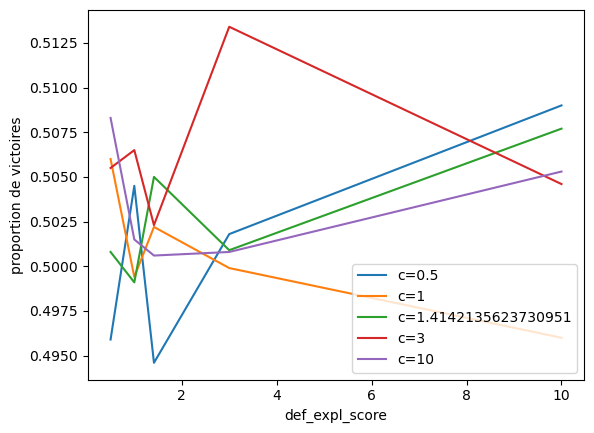

In [24]:
liste_param=[0.5,1,sqrt(2),3,10]
for c in liste_param:
    perf_selon_c=[]
    for default_exploration_score in liste_param:
        evals=[]
        for i in range(10):
            my_player=MctsPlayer(c,default_exploration_score)
            my_player.train(1000)
            eval=eval_against_policy(env, my_player, RandomPlayer(), N_episodes=1000, first_player=True)
            prop_victoires=len([x for x in eval if x==1])/1000
            evals.append(prop_victoires)
        print(f"Proportions de victoires pour c={c} et def_expl_score={default_exploration_score}:")
        print(evals)
        perf_selon_c.append(np.mean(evals))
    plt.plot(liste_param,perf_selon_c,label=f'c={c}')
plt.legend()
plt.xlabel('def_expl_score')
plt.ylabel('proportion de victoires')
plt.show()

In [25]:
c=3
default_exploration_score=3
evals=[]
for i in range(10):
    my_player=MctsPlayer(c,default_exploration_score)
    my_player.train(10000)
    eval=eval_against_policy(env, my_player, RandomPlayer(), N_episodes=1000, first_player=True)
    prop_victoires=len([x for x in eval if x==1])/1000
    evals.append(prop_victoires)
print(f"Proportions de victoires pour c={c} et def_expl_score={default_exploration_score}:")
print(evals)
print('soit en moyenne :',np.mean(evals))

Proportions de victoires pour c=3 et def_expl_score=3:
[0.519, 0.498, 0.514, 0.483, 0.479, 0.519, 0.505, 0.506, 0.489, 0.502]
soit en moyenne : 0.5014


In [26]:
c=3
default_exploration_score=3
evals=[]
for i in range(10):
    my_player=MctsPlayer(c,default_exploration_score)
    my_player.train(50000)
    eval=eval_against_policy(env, my_player, RandomPlayer(), N_episodes=1000, first_player=True)
    prop_victoires=len([x for x in eval if x==1])/1000
    evals.append(prop_victoires)
print(f"Proportions de victoires pour c={c} et def_expl_score={default_exploration_score}:")
print(evals)
print('soit en moyenne :',np.mean(evals))

Proportions de victoires pour c=3 et def_expl_score=3:
[0.486, 0.493, 0.494, 0.52, 0.506, 0.492, 0.508, 0.509, 0.518, 0.509]
soit en moyenne : 0.5035
